<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_08_FFN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

# Explore the MNIST Data Set

In [2]:
# Import the dataset (it comes with colab)
data = np.loadtxt(open("sample_data/mnist_train_small.csv", "rb"), delimiter=",")

In [3]:
data.shape

(20000, 785)

In [4]:
# Extract labels (number IDs) and remove from the data
labels = data[:,0]
data = data[:,1:]
print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


In [5]:
labels[0:15]

array([6., 5., 7., 9., 5., 2., 0., 6., 5., 5., 2., 7., 7., 6., 8.])

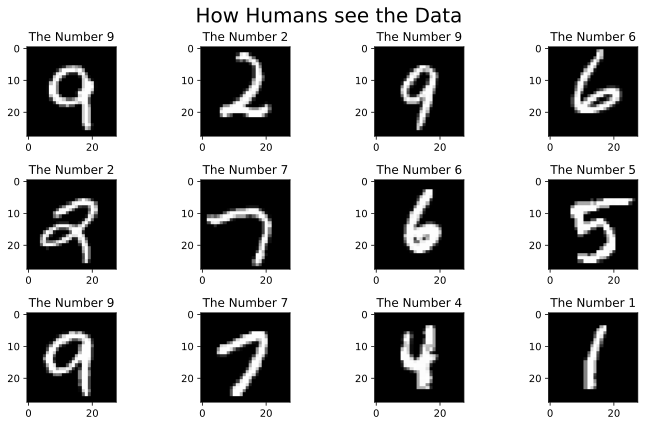

In [8]:
# Plot a few random digits
fig,axs = plt.subplots(3,4,figsize=(10,6))

# We need to reshape the data
for ax in axs.flatten():
    # Pick a random image
    randimg2show = np.random.randint(0, high=data.shape[0])

    # Create the image (must be reshaped)
    img = np.reshape(data[randimg2show,:], (28,28))
    ax.imshow(img, cmap="gray")

    # Title
    ax.set_title("The Number %i"%labels[randimg2show])

plt.suptitle("How Humans see the Data", fontsize=20)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()